### **K Nn Tutorial**

Tutorial: Técnica de Clasificación kNN (k-Nearest Neighbors)

Ricardo Ernesto Hernández Orozco


**Objetivo:** Este notebook explica los fundamentos de la técnica kNN, su formulación básica y muestra una implementación práctica en Python usando `scikit-learn`. Debe poder ejecutarse en Jupyter o Google Colab.

1.1 Fundamentos de la técnica (breve resumen)


kNN (k-Nearest Neighbors) es un algoritmo de clasificación supervisada basado en instancias. Para predecir la clase de un punto nuevo, el algoritmo busca los k ejemplos más cercanos en el conjunto de entrenamiento (según una métrica de distancia, usualmente Euclidiana) y asigna la clase mayoritaria entre esos vecinos. Es un método no paramétrico y muy simple, útil como referencia o para problemas con estructuras locales en el espacio de características.


Ventajas: sencillo, efectivo en muchos problemas, no requiere entrenamiento costoso (almacena los datos).
Limitaciones: costoso en tiempo/espacio para predicción con grandes datasets, sensible a la escala de las características y a la elección de k y la métrica de distancia.

1.2 Modelo matemático


Dado un conjunto de entrenamiento $\{(\mathbf{x}_i, y_i)\}_{i=1}^N$ con $\mathbf{x}_i \in \mathbb{R}^d$ y $y_i$ la etiqueta, para un nuevo punto $\mathbf{x}$ se calcula la distancia $d(\mathbf{x},\mathbf{x}_i)$ (p.ej. Euclidiana):


$$d(\mathbf{x},\mathbf{x}_i)=\|\mathbf{x}-\mathbf{x}_i\|_2 = \sqrt{\sum_{j=1}^d (x_j - x_{i,j})^2}$$


Se seleccionan los k índices con menor distancia y la predicción es la clase mayoritaria entre esos vecinos:


$$\hat{y} = \operatorname{mode}(\{y_i : i\in N_k(\mathbf{x})\})$$


Donde $N_k(\mathbf{x})$ es el conjunto de los k vecinos más cercanos.


También existen variantes que ponderan la contribución de cada vecino por la inversa de la distancia.

1.3 Librerías, clases y funciones (breve descripción)


- `numpy`: operaciones numéricas.
- `pandas`: manejo de datos tabulares.
- `matplotlib.pyplot`: visualizaciones (scatter plot).
- `seaborn` (opcional): visualizaciones estadísticas.
- `sklearn.datasets.load_iris` (o cualquier otro dataset): cargador de datos.
- `sklearn.model_selection.train_test_split`: particionar datos.
- `sklearn.preprocessing.StandardScaler`: estandarizar características (muy importante para kNN).
- `sklearn.neighbors.KNeighborsClassifier`: el clasificador kNN.
- `sklearn.pipeline.Pipeline`: encadenar escalado y modelo.
- `sklearn.metrics.confusion_matrix`, `accuracy_score`, `classification_report`: métricas de evaluación.

1.4. Pipeline

Subsecciones: Preprocesamiento, Feature Engineering, Prediction, Model Evaluation.

In [10]:
# Código: importaciones y carga de datos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report


# Cargar dataset Iris (multi-clase) y preparar DataFrame
iris = datasets.load_iris()
X = iris.data
y = iris.target
columns = iris.feature_names


df = pd.DataFrame(X, columns=columns)
df['target'] = y


print('Dataset Iris cargado, tamaño:', df.shape)
print(df.head())

Dataset Iris cargado, tamaño: (150, 5)
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target  
0       0  
1       0  
2       0  
3       0  
4       0  


Preprocesamiento


- Mostrar análisis estadístico (media, desviación estándar, min, max).
- Visualizar scatter plots (pares de features) para inspeccionar separabilidad.


Estadísticas descriptivas:
                        mean       std  min  max
sepal length (cm)  5.843333  0.828066  4.3  7.9
sepal width (cm)   3.057333  0.435866  2.0  4.4
petal length (cm)  3.758000  1.765298  1.0  6.9
petal width (cm)   1.199333  0.762238  0.1  2.5
target             1.000000  0.819232  0.0  2.0


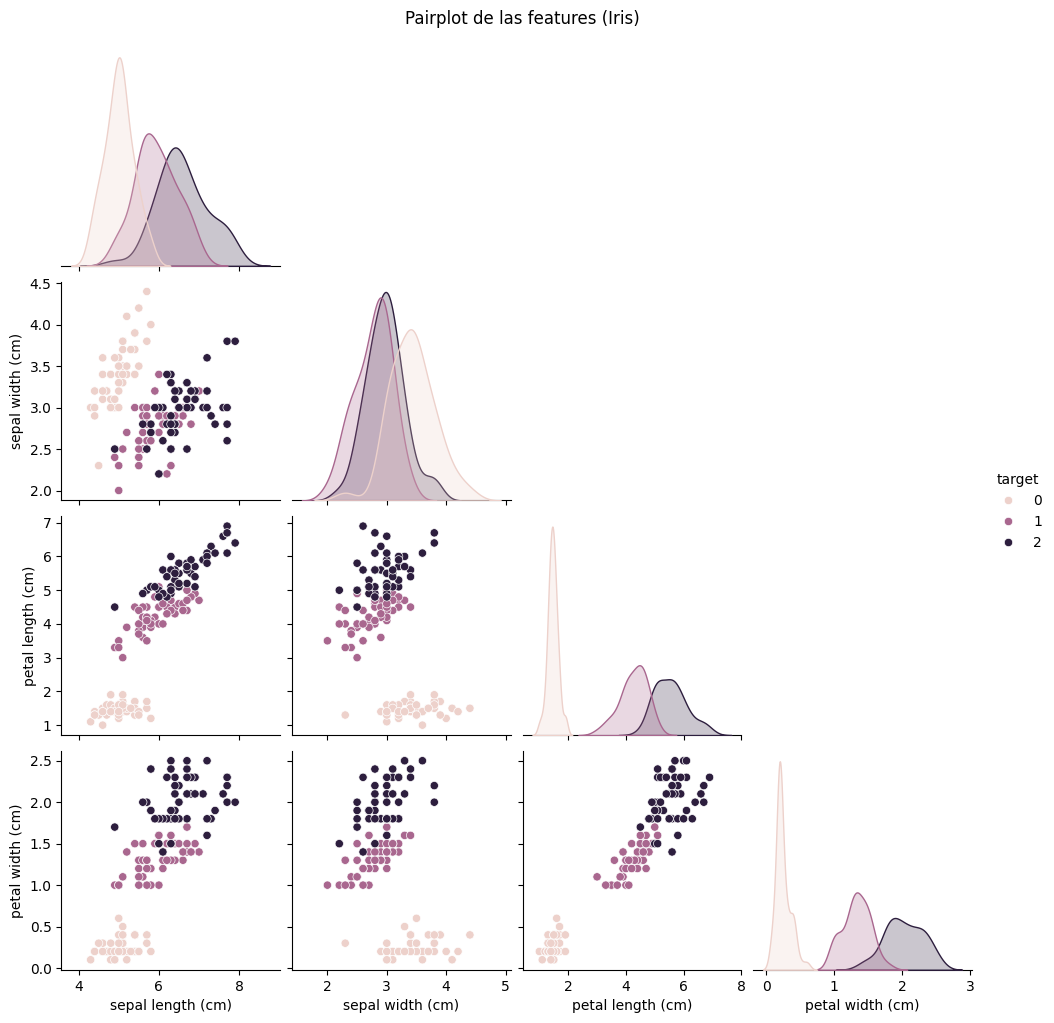

In [11]:
# Estadísticas descriptivas
stats = df.describe().T[['mean','std','min','max']]
print('\nEstadísticas descriptivas:\n', stats)


# Visualización: scatter matrix (pairplot) para observar relaciones entre variables
sns.pairplot(df, hue='target', vars=columns, corner=True)
plt.suptitle('Pairplot de las features (Iris)', y=1.02)
plt.show()

Feature Engineering


- Selección de variables: podemos usar las 4 features originales para kNN. Si se desea reducir dimensionalidad, se puede usar PCA o selección basada en importancia.
- Justificación: en problemas donde la escala importa (kNN usa distancias), mantener features relevantes y estandarizarlas es clave. En este ejemplo usaremos las 4 features porque son informativas para la separación entre especies de Iris.

In [12]:
# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print('\nTamaños: X_train={}, X_test={}'.format(X_train.shape, X_test.shape))


Tamaños: X_train=(105, 4), X_test=(45, 4)


Prediction (función para clasificar un patrón)


Definiremos una función `predict_pattern_knn(pipe, pattern)` que reciba el pipeline entrenado y un patrón, y devuelva la clase predicha (con nombre) y las probabilidades si están disponibles.


In [13]:
# Crear pipeline con StandardScaler + KNeighborsClassifier
k = 5 # valor por defecto de k
pipe_knn = Pipeline([
  ('scaler', StandardScaler()),
  ('knn', KNeighborsClassifier(n_neighbors=k))
])


# Entrenar el pipeline
pipe_knn.fit(X_train, y_train)
print('kNN entrenado con k =', k)


# Función para predecir un patrón
def predict_pattern_knn(model_pipeline, pattern, target_names=iris.target_names):
  """Recibe un pattern (iterable con 4 valores) y devuelve la predicción y probabilidades si aplica."""
  x = np.array(pattern).reshape(1, -1)
  pred = model_pipeline.predict(x)
  # algunos clasificadores permiten predict_proba; KNeighborsClassifier sí lo permite
  probs = None
  if hasattr(model_pipeline.named_steps['knn'], 'predict_proba'):
    probs = model_pipeline.predict_proba(x)[0]
  return {'pattern': pattern, 'pred_label': int(pred[0]), 'pred_name': target_names[int(pred[0])], 'probs': probs}


# Probar la función con un ejemplo del test set
print(predict_pattern_knn(pipe_knn, X_test[0]))

kNN entrenado con k = 5
{'pattern': array([7.3, 2.9, 6.3, 1.8]), 'pred_label': 2, 'pred_name': np.str_('virginica'), 'probs': array([0., 0., 1.])}


Model Evaluation


Calcularemos la matriz de confusión y la Accuracy. También mostraremos un reporte de clasificación.

Accuracy: 0.9111111111111111

Matriz de confusión:
 [[15  0  0]
 [ 0 15  0]
 [ 0  4 11]]

Reporte de clasificación:
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.79      1.00      0.88        15
   virginica       1.00      0.73      0.85        15

    accuracy                           0.91        45
   macro avg       0.93      0.91      0.91        45
weighted avg       0.93      0.91      0.91        45



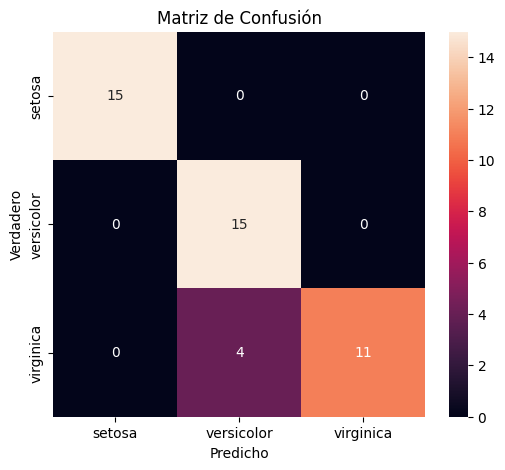

In [14]:
# Predicciones sobre el conjunto de prueba
y_pred = pipe_knn.predict(X_test)


# Métricas
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=iris.target_names)


print('Accuracy:', acc)
print('\nMatriz de confusión:\n', cm)
print('\nReporte de clasificación:\n', report)


# Mostrar matriz de confusión con heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=iris.target_names, yticklabels=iris.target_names)
plt.xlabel('Predicho')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión')
plt.show()


# Breve interpretación:
# - La accuracy nos da la fracción de predicciones correctas.
# - La matriz de confusión muestra dónde se concentran los errores por clase.

Referencias bibliográficas

Cover, T., & Hart, P. (1967). Nearest neighbor pattern classification. *IEEE Transactions on Information Theory, 13*(1), 21–27.


Duda, R. O., Hart, P. E., & Stork, D. G. (2001). *Pattern Classification* (2nd ed.). Wiley.


Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., ... & Duchesnay, É. (2011). Scikit-learn: Machine learning in Python. *Journal of Machine Learning Research, 12*, 2825–2830.